In [3]:
# %load_ext autoreload   # falls noch nicht aktiv
# %autoreload 2

import sys, os, time, json
from pathlib import Path

# === Projekt-Root auf sys.path ===
# -> Passe das bei Bedarf an. Ziel: "image_recommender/core.py" muss importierbar sein.
CANDIDATES = [
    Path.cwd(),
    Path.cwd().parent,
    Path(r"C:\BIG_DATA\src"),         # dein typischer Pfad
    Path(r"Z:\CODING\UNI\BIG_DATA\src"),
]
added = False
for root in CANDIDATES:
    if (root / "image_recommender" / "core.py").exists():
        if str(root) not in sys.path:
            sys.path.insert(0, str(root))
            added = True
        break
print("sys.path OK:", added, "->", sys.path[0])


sys.path OK: False -> Z:\Python311\python311.zip


In [5]:
from pathlib import Path
import sys

# Kandidaten: CWD und Eltern
roots = [Path.cwd(), *Path.cwd().parents]
added = False
for root in roots:
    if (root / "engine" / "core.py").exists() or (root / "image_recommender" / "core.py").exists():
        if str(root) not in sys.path:
            sys.path.insert(0, str(root))
            added = True
        break
print("sys.path set:", added, " ->", sys.path[0])

# Falls engine als Paket genutzt wird, sicherstellen, dass __init__.py existiert
for pkg in ("engine", "image_recommender"):
    p = Path(pkg)
    if p.exists() and (p / "core.py").exists():
        (p / "__init__.py").touch()


sys.path set: True  -> z:\CODING\UNI\BIG_DATA\src


In [ ]:
from engine.core import Config, warmup, search_once
from pathlib import Path

# --- Pfade anpassen ---
DB = Path(r"C:\BIG_DATA\data\database.db")

# Optional: Spaltenname für Farb-Histogramm (TEXT/CSV, 96 Werte)
HIST_COL = "color_hist"   # ggf. auf deinen Namen ändern

# Start-Config (du kannst pro Run überschreiben)
cfg = Config(
    mode= "mix",
    hist_col_text=HIST_COL,
    top_k=20,
    x_factor=96,   # kleiner als 160 -> weniger I/O, schneller
    y_factor=16,
    m_factor=6,
    hnsw_ef_search=120,
    fusion_enabled=True,
)

print(cfg)


Config(models_dir=WindowsPath('C:/BIG_DATA/models'), ipca_path=WindowsPath('C:/BIG_DATA/models/ipca.joblib'), index_dir=WindowsPath('C:/BIG_DATA/ann_index_32d'), index_bin='hnsw_32d.bin', index_meta='labels_meta.pkl', hnsw_M=16, hnsw_ef_construction=200, hnsw_ef_search=120, table_prefix='image_features_part_', col_id='id', col_image_path='path', col_emb32='pca_32', col_emb64='pca_embedding', col_emb512='embedding_path', hist_col_text='color_hist', color_bins=32, top_k=20, x_factor=96, y_factor=16, m_factor=6, target_size=(224, 224), fusion_enabled=True, weights_json=WindowsPath('C:/BIG_DATA/eval/weight_grid_db.json'), fusion_weights_manual={'cos': 0.65, 'lpips': 0.25, 'ssim': 0.1, 'color': 0.1}, use_threads=True)


In [ ]:
t0 = time.time()
warmup(DB, cfg)  # lädt IPCA, Index, Embedding-Extractor in den Cache
print(f"Warmup fertig in {time.time()-t0:.2f}s")


Warmup fertig in 0.00s


In [12]:
import cv2
import numpy as np
from typing import Dict, Any, List

def run_query(img_path: str | Path, cfg_override: Dict[str, Any] | None = None, print_top_n: int = 5):
    """Führt eine Suche aus und gibt (result, elapsed_s) zurück."""
    _cfg = cfg if cfg_override is None else Config(**{**cfg.__dict__, **cfg_override})
    t0 = time.time()
    out = search_once(Path(img_path), DB, _cfg)
    dt = time.time() - t0
    # Kompakt drucken
    to_print = {
        "query": out.get("query", {}),
        "results": {"final_top_k": out["results"]["final_top_k"][:print_top_n]},
        "params": out.get("params", {})
    }
    print(json.dumps(to_print, ensure_ascii=False, indent=2))
    print(f"[TIME] {img_path}  {dt:.3f}s")
    return out, dt

def show_grid(items: List[Dict], cols: int = 5, size=(224,224)):
    """Zeigt die Trefferbilder im Grid (BGR→RGB)."""
    import matplotlib.pyplot as plt

    n = min(len(items), cols * ((len(items)+cols-1)//cols))
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols*3, rows*3))
    for i, it in enumerate(items[:n]):
        p = it["image_path"]
        try:
            data = np.fromfile(p, dtype=np.uint8)
            img  = cv2.imdecode(data, cv2.IMREAD_COLOR)
            if img is None: raise ValueError("decode failed")
            img  = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
            img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            title = f'#{i+1}  s={it.get("score_fused", it.get("score", 0)):.3f}'
        except Exception as e:
            img = np.zeros((size[1], size[0], 3), dtype=np.uint8)
            title = f'#{i+1}  (ERR)'

        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(title, fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


{
  "query": {
    "image_path": "Z:\\CODING\\UNI\\BIG_DATA\\data\\TEST_IMAGES\\nature-landscape-pictures-hg4ndx87jp1rsvth.jpg"
  },
  "results": {
    "final_top_k": [
      {
        "label": "512D",
        "score": 0.9999328851699829,
        "rank": 68,
        "table": "image_features_part_6",
        "id": 17167,
        "image_path": "D:\\data\\image_data\\pexels_dataset_v1\\images_04\\person-showing-gray-mountain-534164.jpeg",
        "path_32": "C:\\BIG_DATA\\embeddings_pca32\\image_features_part_6\\17167_pca32.npy",
        "path_64": "C:\\BIG_DATA\\embeddings_pca\\17167_pca_5.npy",
        "path_512": "C:\\BIG_DATA\\embeddings\\person-showing-gray-mountain-534164.jpeg.npy",
        "sim_color": 0.7553512454032898,
        "score_cos512": 0.9999328851699829,
        "score_fused": 0.5755015671253204
      },
      {
        "label": "512D",
        "score": 0.9999321699142456,
        "rank": 75,
        "table": "image_features_part_4",
        "id": 42146,
        "image_p

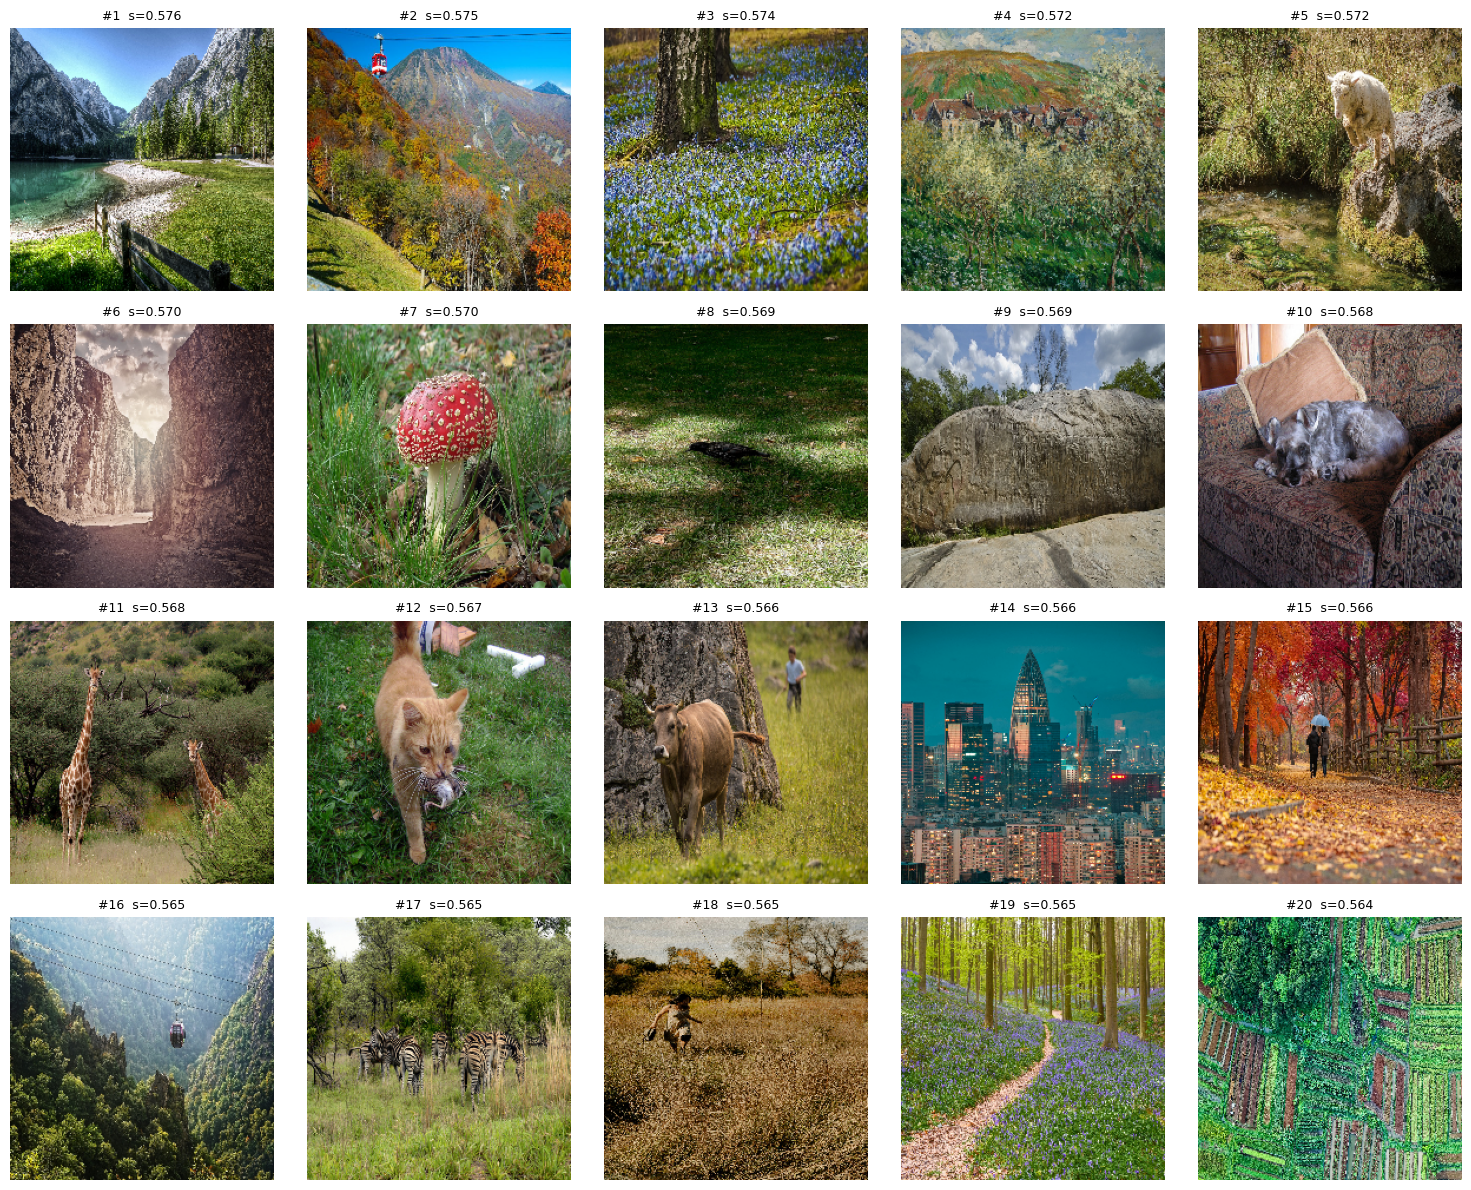

In [13]:
IMG = Path(r"Z:\CODING\UNI\BIG_DATA\data\TEST_IMAGES\nature-landscape-pictures-hg4ndx87jp1rsvth.jpg")  # anpassen

res, dt = run_query(IMG, print_top_n=5)
show_grid(res["results"]["final_top_k"], cols=5)
